In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the directory path
data_dir = r"D:\archive (1)\PlantVillage"

# Load the entire dataset
full_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Define the sizes of each split
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# Print class names
print(full_dataset.classes)

# Custom RegNetX600-like model definition for 64x64 images
class CustomRegNetX600(nn.Module):
    def __init__(self, num_classes=15, in_channels=3, dropout_rate=0.2):
        super(CustomRegNetX600, self).__init__()

        # Stem convolutional layer
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # Blocks (similar to RegNetX's design)
        self.blocks = nn.Sequential(
            BottleneckBlock(32, 24, 3, 1, dropout_rate),
            BottleneckBlock(24, 56, 4, 2, dropout_rate),
            BottleneckBlock(56, 152, 6, 2, dropout_rate),
            BottleneckBlock(152, 368, 8, 2, dropout_rate),
            BottleneckBlock(368, 880, 6, 1, dropout_rate),
            BottleneckBlock(880, 2112, 3, 1, dropout_rate)
        )

        # Classifier head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(2112, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.classifier(x)
        return x


class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, stride, dropout_rate):
        super(BottleneckBlock, self).__init__()

        layers = []
        for _ in range(num_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        
        layers.append(nn.Dropout(dropout_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


# Print the model architecture
model = CustomRegNetX600(num_classes=15).to(device)
print(model)



['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
CustomRegNetX600(
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (blocks): Sequential(
    (0): BottleneckBlock(
      (block): Sequential(
        (0): Conv2d(32, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1


Training with learning rate: 0.001


Epoch [1/50], Train Loss: 2.3578, Train Accuracy: 0.2119, Val Loss: 2.1658, Val Accuracy: 0.2773


Epoch [2/50], Train Loss: 2.1513, Train Accuracy: 0.2749, Val Loss: 2.2731, Val Accuracy: 0.2492


Epoch [3/50], Train Loss: 2.0899, Train Accuracy: 0.3013, Val Loss: 2.0447, Val Accuracy: 0.3505


Epoch [4/50], Train Loss: 1.8923, Train Accuracy: 0.3710, Val Loss: 1.7512, Val Accuracy: 0.4120


Epoch [5/50], Train Loss: 1.8868, Train Accuracy: 0.3779, Val Loss: 2.3298, Val Accuracy: 0.2962


Epoch [6/50], Train Loss: 2.4177, Train Accuracy: 0.2435, Val Loss: 2.4717, Val Accuracy: 0.1755


Epoch [7/50], Train Loss: 2.3521, Train Accuracy: 0.2652, Val Loss: 2.1398, Val Accuracy: 0.2957


Epoch [8/50], Train Loss: 2.1276, Train Accuracy: 0.3165, Val Loss: 2.7869, Val Accuracy: 0.3160


Epoch [9/50], Train Loss: 2.1150, Train Accuracy: 0.3249, Val Loss: 2.1958, Val Accuracy: 0.2967


Epoch [10/50], Train Loss: 2.0036, Train Accuracy: 0.3589, Val Loss: 1.9212, Val Accuracy: 0.3946


Epoch [11/50], Train Loss: 1.8576, Train Accuracy: 0.3889, Val Loss: 1.6823, Val Accuracy: 0.4251


Epoch [12/50], Train Loss: 1.7016, Train Accuracy: 0.4319, Val Loss: 1.6311, Val Accuracy: 0.4309


Epoch [13/50], Train Loss: 1.5767, Train Accuracy: 0.4729, Val Loss: 1.4936, Val Accuracy: 0.5240


Epoch [14/50], Train Loss: 1.4479, Train Accuracy: 0.5273, Val Loss: 1.3001, Val Accuracy: 0.5773


Epoch [15/50], Train Loss: 1.4060, Train Accuracy: 0.5588, Val Loss: 1.2622, Val Accuracy: 0.5986


Epoch [16/50], Train Loss: 1.3059, Train Accuracy: 0.5915, Val Loss: 1.2050, Val Accuracy: 0.5982


Epoch [17/50], Train Loss: 1.2957, Train Accuracy: 0.5949, Val Loss: 1.2961, Val Accuracy: 0.5875


Epoch [18/50], Train Loss: 1.4762, Train Accuracy: 0.5557, Val Loss: 2.1879, Val Accuracy: 0.4120


Epoch [19/50], Train Loss: 1.5570, Train Accuracy: 0.4905, Val Loss: 1.3336, Val Accuracy: 0.5613


Epoch [20/50], Train Loss: 1.3081, Train Accuracy: 0.5842, Val Loss: 1.3784, Val Accuracy: 0.5909


Epoch [21/50], Train Loss: 1.2227, Train Accuracy: 0.6172, Val Loss: 1.0806, Val Accuracy: 0.6500


Epoch [22/50], Train Loss: 1.2133, Train Accuracy: 0.6209, Val Loss: 1.2673, Val Accuracy: 0.6127


Epoch [23/50], Train Loss: 1.1716, Train Accuracy: 0.6363, Val Loss: 1.1150, Val Accuracy: 0.6573


Epoch [24/50], Train Loss: 1.1616, Train Accuracy: 0.6382, Val Loss: 1.0583, Val Accuracy: 0.6714


Epoch [25/50], Train Loss: 1.0610, Train Accuracy: 0.6703, Val Loss: 1.1713, Val Accuracy: 0.6394


Epoch [26/50], Train Loss: 1.0894, Train Accuracy: 0.6698, Val Loss: 1.0869, Val Accuracy: 0.6810


Epoch [27/50], Train Loss: 1.3738, Train Accuracy: 0.5768, Val Loss: 1.1214, Val Accuracy: 0.6481


Epoch [28/50], Train Loss: 1.0868, Train Accuracy: 0.6721, Val Loss: 1.1369, Val Accuracy: 0.6626


Epoch [29/50], Train Loss: 1.0985, Train Accuracy: 0.6736, Val Loss: 1.3795, Val Accuracy: 0.5817


Epoch [30/50], Train Loss: 1.1323, Train Accuracy: 0.6578, Val Loss: 0.9186, Val Accuracy: 0.7043


Epoch [31/50], Train Loss: 1.0985, Train Accuracy: 0.6689, Val Loss: 1.0456, Val Accuracy: 0.6680


Epoch [32/50], Train Loss: 0.9656, Train Accuracy: 0.7114, Val Loss: 0.8078, Val Accuracy: 0.7576


Epoch [33/50], Train Loss: 0.9650, Train Accuracy: 0.7147, Val Loss: 0.9545, Val Accuracy: 0.7256


Epoch [34/50], Train Loss: 1.0283, Train Accuracy: 0.6964, Val Loss: 1.3590, Val Accuracy: 0.5700


Epoch [35/50], Train Loss: 1.0409, Train Accuracy: 0.6935, Val Loss: 1.1479, Val Accuracy: 0.6306


Epoch [36/50], Train Loss: 0.9659, Train Accuracy: 0.7122, Val Loss: 0.9993, Val Accuracy: 0.6646


Epoch [37/50], Train Loss: 1.0884, Train Accuracy: 0.6806, Val Loss: 1.7507, Val Accuracy: 0.5899


Epoch [38/50], Train Loss: 1.0523, Train Accuracy: 0.6887, Val Loss: 0.8697, Val Accuracy: 0.7106


Epoch [39/50], Train Loss: 1.1201, Train Accuracy: 0.6636, Val Loss: 1.1495, Val Accuracy: 0.6515


Epoch [40/50], Train Loss: 1.1450, Train Accuracy: 0.6565, Val Loss: 0.9138, Val Accuracy: 0.7130


Epoch [41/50], Train Loss: 0.9776, Train Accuracy: 0.7118, Val Loss: 0.8449, Val Accuracy: 0.7479


Epoch [42/50], Train Loss: 0.9508, Train Accuracy: 0.7228, Val Loss: 0.9976, Val Accuracy: 0.6937


Epoch [43/50], Train Loss: 0.9219, Train Accuracy: 0.7337, Val Loss: 0.8795, Val Accuracy: 0.7402


Epoch [44/50], Train Loss: 0.8851, Train Accuracy: 0.7402, Val Loss: 0.8590, Val Accuracy: 0.7363


Epoch [45/50], Train Loss: 1.2033, Train Accuracy: 0.6703, Val Loss: 20.0877, Val Accuracy: 0.4838


Epoch [46/50], Train Loss: 1.3469, Train Accuracy: 0.5921, Val Loss: 2.0422, Val Accuracy: 0.3829


Epoch [47/50], Train Loss: 1.8752, Train Accuracy: 0.4534, Val Loss: 1.4825, Val Accuracy: 0.5565


Epoch [48/50], Train Loss: 1.3315, Train Accuracy: 0.5956, Val Loss: 1.1345, Val Accuracy: 0.6539


Epoch [49/50], Train Loss: 1.3152, Train Accuracy: 0.6063, Val Loss: 1.1239, Val Accuracy: 0.6447


Epoch [50/50], Train Loss: 1.1675, Train Accuracy: 0.6575, Val Loss: 1.0065, Val Accuracy: 0.6752
Test Loss: 1.0084, Test Accuracy: 0.6891

Training with learning rate: 0.0001


Epoch [1/50], Train Loss: 2.5628, Train Accuracy: 0.1608, Val Loss: 2.7099, Val Accuracy: 0.1018


Epoch [2/50], Train Loss: 2.4355, Train Accuracy: 0.2012, Val Loss: 2.9257, Val Accuracy: 0.0887


Epoch [3/50], Train Loss: 2.3257, Train Accuracy: 0.2356, Val Loss: 2.6071, Val Accuracy: 0.1726


Epoch [4/50], Train Loss: 2.2170, Train Accuracy: 0.2715, Val Loss: 2.4031, Val Accuracy: 0.2395


Epoch [5/50], Train Loss: 2.0534, Train Accuracy: 0.3235, Val Loss: 2.2118, Val Accuracy: 0.2933


Epoch [6/50], Train Loss: 1.9471, Train Accuracy: 0.3536, Val Loss: 2.1142, Val Accuracy: 0.3228


Epoch [7/50], Train Loss: 1.8427, Train Accuracy: 0.3859, Val Loss: 2.0278, Val Accuracy: 0.3737


Epoch [8/50], Train Loss: 1.7613, Train Accuracy: 0.4181, Val Loss: 1.8283, Val Accuracy: 0.3873


Epoch [9/50], Train Loss: 1.6455, Train Accuracy: 0.4565, Val Loss: 1.6964, Val Accuracy: 0.4464


Epoch [10/50], Train Loss: 1.5245, Train Accuracy: 0.4997, Val Loss: 1.6232, Val Accuracy: 0.4852


Epoch [11/50], Train Loss: 1.4005, Train Accuracy: 0.5386, Val Loss: 1.4207, Val Accuracy: 0.5347


Epoch [12/50], Train Loss: 1.2991, Train Accuracy: 0.5718, Val Loss: 1.2685, Val Accuracy: 0.5851


Epoch [13/50], Train Loss: 1.2197, Train Accuracy: 0.5945, Val Loss: 1.2625, Val Accuracy: 0.5788


Epoch [14/50], Train Loss: 1.1277, Train Accuracy: 0.6292, Val Loss: 1.0991, Val Accuracy: 0.6384


Epoch [15/50], Train Loss: 1.0643, Train Accuracy: 0.6494, Val Loss: 1.0694, Val Accuracy: 0.6694


Epoch [16/50], Train Loss: 0.9910, Train Accuracy: 0.6770, Val Loss: 0.9525, Val Accuracy: 0.6849


Epoch [17/50], Train Loss: 0.9251, Train Accuracy: 0.7002, Val Loss: 0.9259, Val Accuracy: 0.7048


Epoch [18/50], Train Loss: 0.8585, Train Accuracy: 0.7274, Val Loss: 0.8081, Val Accuracy: 0.7271


Epoch [19/50], Train Loss: 0.7911, Train Accuracy: 0.7543, Val Loss: 0.8957, Val Accuracy: 0.7189


Epoch [20/50], Train Loss: 0.7138, Train Accuracy: 0.7752, Val Loss: 0.6285, Val Accuracy: 0.8013


Epoch [21/50], Train Loss: 0.6746, Train Accuracy: 0.7915, Val Loss: 0.6487, Val Accuracy: 0.7896


Epoch [22/50], Train Loss: 0.6466, Train Accuracy: 0.8034, Val Loss: 0.6776, Val Accuracy: 0.7916


Epoch [23/50], Train Loss: 0.6030, Train Accuracy: 0.8202, Val Loss: 0.6178, Val Accuracy: 0.8182


Epoch [24/50], Train Loss: 0.5671, Train Accuracy: 0.8284, Val Loss: 0.7743, Val Accuracy: 0.7639


Epoch [25/50], Train Loss: 0.5340, Train Accuracy: 0.8400, Val Loss: 0.4917, Val Accuracy: 0.8483


Epoch [26/50], Train Loss: 0.5019, Train Accuracy: 0.8505, Val Loss: 0.7113, Val Accuracy: 0.7921


Epoch [27/50], Train Loss: 0.4836, Train Accuracy: 0.8573, Val Loss: 0.4966, Val Accuracy: 0.8541


Epoch [28/50], Train Loss: 0.4468, Train Accuracy: 0.8698, Val Loss: 0.4772, Val Accuracy: 0.8628


Epoch [29/50], Train Loss: 0.4247, Train Accuracy: 0.8746, Val Loss: 0.4166, Val Accuracy: 0.8759


Epoch [30/50], Train Loss: 0.4107, Train Accuracy: 0.8810, Val Loss: 0.4138, Val Accuracy: 0.8745


Epoch [31/50], Train Loss: 0.3941, Train Accuracy: 0.8847, Val Loss: 0.3944, Val Accuracy: 0.8880


Epoch [32/50], Train Loss: 0.3699, Train Accuracy: 0.8922, Val Loss: 0.4105, Val Accuracy: 0.8774


Epoch [33/50], Train Loss: 0.3634, Train Accuracy: 0.8935, Val Loss: 0.5591, Val Accuracy: 0.8449


Epoch [34/50], Train Loss: 0.3343, Train Accuracy: 0.9055, Val Loss: 0.4261, Val Accuracy: 0.8783


Epoch [35/50], Train Loss: 0.3334, Train Accuracy: 0.9038, Val Loss: 0.4054, Val Accuracy: 0.8817


Epoch [36/50], Train Loss: 0.3377, Train Accuracy: 0.9076, Val Loss: 0.3760, Val Accuracy: 0.8914


Epoch [37/50], Train Loss: 0.3052, Train Accuracy: 0.9116, Val Loss: 0.3723, Val Accuracy: 0.8943


Epoch [38/50], Train Loss: 0.3034, Train Accuracy: 0.9148, Val Loss: 0.3228, Val Accuracy: 0.9084


Epoch [39/50], Train Loss: 0.2680, Train Accuracy: 0.9222, Val Loss: 0.3175, Val Accuracy: 0.9127


Epoch [40/50], Train Loss: 0.2629, Train Accuracy: 0.9268, Val Loss: 0.2816, Val Accuracy: 0.9142


Epoch [41/50], Train Loss: 0.2635, Train Accuracy: 0.9260, Val Loss: 0.2809, Val Accuracy: 0.9186


Epoch [42/50], Train Loss: 0.2508, Train Accuracy: 0.9328, Val Loss: 0.3043, Val Accuracy: 0.9113


Epoch [43/50], Train Loss: 0.2519, Train Accuracy: 0.9280, Val Loss: 0.3618, Val Accuracy: 0.8963


Epoch [44/50], Train Loss: 0.2285, Train Accuracy: 0.9349, Val Loss: 0.3236, Val Accuracy: 0.9098


Epoch [45/50], Train Loss: 0.2321, Train Accuracy: 0.9363, Val Loss: 0.2960, Val Accuracy: 0.9137


Epoch [46/50], Train Loss: 0.2115, Train Accuracy: 0.9419, Val Loss: 0.3309, Val Accuracy: 0.9069


Epoch [47/50], Train Loss: 0.2038, Train Accuracy: 0.9442, Val Loss: 0.2582, Val Accuracy: 0.9215


Epoch [48/50], Train Loss: 0.2080, Train Accuracy: 0.9427, Val Loss: 0.2498, Val Accuracy: 0.9307


Epoch [49/50], Train Loss: 0.1915, Train Accuracy: 0.9474, Val Loss: 0.2642, Val Accuracy: 0.9312


Epoch [50/50], Train Loss: 0.1758, Train Accuracy: 0.9498, Val Loss: 0.3326, Val Accuracy: 0.9118
Test Loss: 0.4052, Test Accuracy: 0.8988

Training with learning rate: 1e-05


Epoch [1/50], Train Loss: 2.6631, Train Accuracy: 0.1280, Val Loss: 2.7784, Val Accuracy: 0.0989


Epoch [2/50], Train Loss: 2.5693, Train Accuracy: 0.1534, Val Loss: 2.7083, Val Accuracy: 0.1057


Epoch [3/50], Train Loss: 2.5376, Train Accuracy: 0.1601, Val Loss: 2.7288, Val Accuracy: 0.1062


Epoch [4/50], Train Loss: 2.5104, Train Accuracy: 0.1714, Val Loss: 2.7083, Val Accuracy: 0.1120


Epoch [5/50], Train Loss: 2.5050, Train Accuracy: 0.1744, Val Loss: 2.7378, Val Accuracy: 0.1081


Epoch [6/50], Train Loss: 2.4877, Train Accuracy: 0.1746, Val Loss: 2.7343, Val Accuracy: 0.1149


Epoch [7/50], Train Loss: 2.4659, Train Accuracy: 0.1843, Val Loss: 2.7543, Val Accuracy: 0.1163


Epoch [8/50], Train Loss: 2.4545, Train Accuracy: 0.1900, Val Loss: 2.7273, Val Accuracy: 0.1226


Epoch [9/50], Train Loss: 2.4482, Train Accuracy: 0.1898, Val Loss: 2.7006, Val Accuracy: 0.1348


Epoch [10/50], Train Loss: 2.4318, Train Accuracy: 0.1939, Val Loss: 2.7124, Val Accuracy: 0.1406


Epoch [11/50], Train Loss: 2.4141, Train Accuracy: 0.1984, Val Loss: 2.7543, Val Accuracy: 0.1440


Epoch [12/50], Train Loss: 2.4078, Train Accuracy: 0.2014, Val Loss: 2.7108, Val Accuracy: 0.1323


Epoch [13/50], Train Loss: 2.4012, Train Accuracy: 0.2018, Val Loss: 2.6749, Val Accuracy: 0.1474


Epoch [14/50], Train Loss: 2.3898, Train Accuracy: 0.2027, Val Loss: 2.7001, Val Accuracy: 0.1478


Epoch [15/50], Train Loss: 2.3763, Train Accuracy: 0.2060, Val Loss: 2.7140, Val Accuracy: 0.1377


Epoch [16/50], Train Loss: 2.3633, Train Accuracy: 0.2139, Val Loss: 2.6641, Val Accuracy: 0.1585


Epoch [17/50], Train Loss: 2.3485, Train Accuracy: 0.2129, Val Loss: 2.6619, Val Accuracy: 0.1207


Epoch [18/50], Train Loss: 2.3450, Train Accuracy: 0.2144, Val Loss: 2.6444, Val Accuracy: 0.1571


Epoch [19/50], Train Loss: 2.3380, Train Accuracy: 0.2136, Val Loss: 2.6291, Val Accuracy: 0.1527


Epoch [20/50], Train Loss: 2.3220, Train Accuracy: 0.2204, Val Loss: 2.6008, Val Accuracy: 0.1527


Epoch [21/50], Train Loss: 2.3034, Train Accuracy: 0.2254, Val Loss: 2.6046, Val Accuracy: 0.1566


Epoch [22/50], Train Loss: 2.2984, Train Accuracy: 0.2299, Val Loss: 2.6093, Val Accuracy: 0.1444


Epoch [23/50], Train Loss: 2.2840, Train Accuracy: 0.2320, Val Loss: 2.6050, Val Accuracy: 0.1663


Epoch [24/50], Train Loss: 2.2744, Train Accuracy: 0.2325, Val Loss: 2.5926, Val Accuracy: 0.1532


Epoch [25/50], Train Loss: 2.2554, Train Accuracy: 0.2461, Val Loss: 2.4926, Val Accuracy: 0.1871


Epoch [26/50], Train Loss: 2.2370, Train Accuracy: 0.2517, Val Loss: 2.5251, Val Accuracy: 0.1789


Epoch [27/50], Train Loss: 2.2251, Train Accuracy: 0.2557, Val Loss: 2.5043, Val Accuracy: 0.1861


Epoch [28/50], Train Loss: 2.2091, Train Accuracy: 0.2588, Val Loss: 2.4575, Val Accuracy: 0.1987


Epoch [29/50], Train Loss: 2.1858, Train Accuracy: 0.2697, Val Loss: 2.4561, Val Accuracy: 0.2055


Epoch [30/50], Train Loss: 2.1601, Train Accuracy: 0.2773, Val Loss: 2.4002, Val Accuracy: 0.2147


Epoch [31/50], Train Loss: 2.1389, Train Accuracy: 0.2838, Val Loss: 2.3570, Val Accuracy: 0.2298


Epoch [32/50], Train Loss: 2.1119, Train Accuracy: 0.2955, Val Loss: 2.2847, Val Accuracy: 0.2482


Epoch [33/50], Train Loss: 2.0856, Train Accuracy: 0.3018, Val Loss: 2.2438, Val Accuracy: 0.2521


Epoch [34/50], Train Loss: 2.0552, Train Accuracy: 0.3088, Val Loss: 2.2591, Val Accuracy: 0.2608


Epoch [35/50], Train Loss: 2.0243, Train Accuracy: 0.3154, Val Loss: 2.1693, Val Accuracy: 0.2695


Epoch [36/50], Train Loss: 2.0022, Train Accuracy: 0.3271, Val Loss: 2.1543, Val Accuracy: 0.2802


Epoch [37/50], Train Loss: 1.9885, Train Accuracy: 0.3290, Val Loss: 2.1293, Val Accuracy: 0.2865


Epoch [38/50], Train Loss: 1.9652, Train Accuracy: 0.3400, Val Loss: 2.0773, Val Accuracy: 0.3000


Epoch [39/50], Train Loss: 1.9370, Train Accuracy: 0.3518, Val Loss: 2.0144, Val Accuracy: 0.3311


Epoch [40/50], Train Loss: 1.9138, Train Accuracy: 0.3567, Val Loss: 1.9744, Val Accuracy: 0.3393


Epoch [41/50], Train Loss: 1.8861, Train Accuracy: 0.3674, Val Loss: 1.9544, Val Accuracy: 0.3456


Epoch [42/50], Train Loss: 1.8619, Train Accuracy: 0.3745, Val Loss: 1.9497, Val Accuracy: 0.3456


Epoch [43/50], Train Loss: 1.8377, Train Accuracy: 0.3812, Val Loss: 1.9219, Val Accuracy: 0.3558


Epoch [44/50], Train Loss: 1.8237, Train Accuracy: 0.3846, Val Loss: 1.8945, Val Accuracy: 0.3674


Epoch [45/50], Train Loss: 1.7856, Train Accuracy: 0.4004, Val Loss: 1.8363, Val Accuracy: 0.3795


Epoch [46/50], Train Loss: 1.7689, Train Accuracy: 0.4090, Val Loss: 1.8538, Val Accuracy: 0.3723


Epoch [47/50], Train Loss: 1.7601, Train Accuracy: 0.4039, Val Loss: 1.8141, Val Accuracy: 0.3965


Epoch [48/50], Train Loss: 1.7468, Train Accuracy: 0.4126, Val Loss: 1.8231, Val Accuracy: 0.3941


Epoch [49/50], Train Loss: 1.7126, Train Accuracy: 0.4233, Val Loss: 1.8159, Val Accuracy: 0.3955


Epoch [50/50], Train Loss: 1.6824, Train Accuracy: 0.4343, Val Loss: 1.7445, Val Accuracy: 0.4052
Test Loss: 1.7783, Test Accuracy: 0.4068


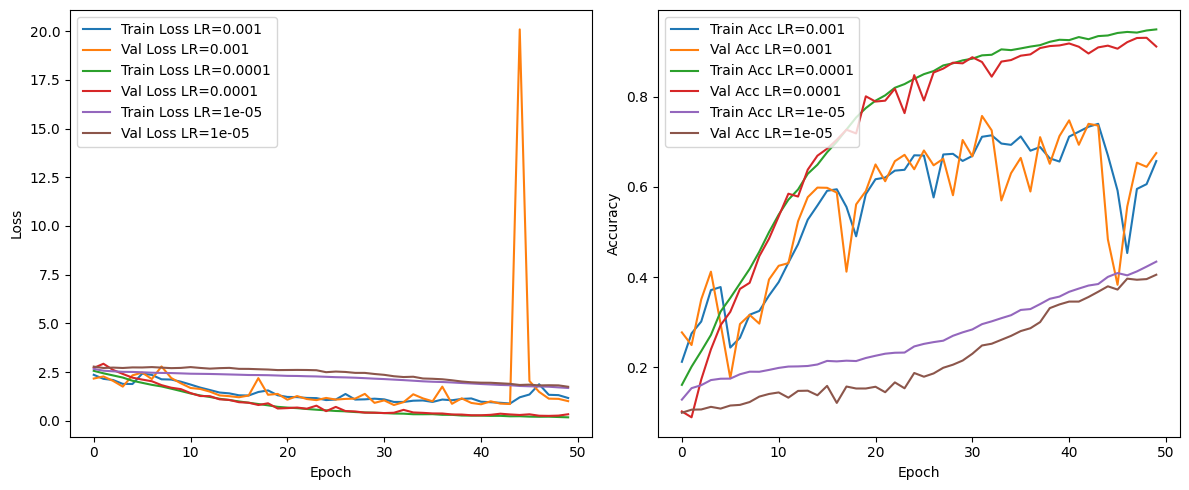

In [2]:

# Define the evaluation function
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Define the training and evaluation function
def train_and_evaluate_model(model, train_loader, val_loader, test_loader, criterion, num_epochs, lr, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Define the learning rates to evaluate
learning_rates = [1e-3, 1e-4, 1e-5]

# Initialize the model and criterion
model = CustomRegNetX600(num_classes=15).to(device)
criterion = nn.CrossEntropyLoss()

# Loop through learning rates
results = {}
for lr in learning_rates:
    print(f'\nTraining with learning rate: {lr}')
    model = CustomRegNetX600(num_classes=15).to(device)
    train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, test_loader, criterion, num_epochs=50, lr=lr, device=device)
    results[lr] = (train_losses, val_losses, train_accuracies, val_accuracies)

# Plot the results
plt.figure(figsize=(12, 5))

for lr, (train_losses, val_losses, train_accuracies, val_accuracies) in results.items():
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Train Loss LR={lr}')
    plt.plot(val_losses, label=f'Val Loss LR={lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f'Train Acc LR={lr}')
    plt.plot(val_accuracies, label=f'Val Acc LR={lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()
